In [10]:
from tensorflow.keras.models import load_model
from math import floor
import cv2
import numpy as np

keys = {0:'一溝黃',
        1:'二~三溝黃',
        2:'四~五溝黃',
        3:'催熟後(50-75%黃)',
        4:'全黃(75-100%黃)',
        5:'其他'}

model_unet = load_model('09_final_weight/unet_resnet18.h5')
model_classification = load_model('09_final_weight/classification_mobilenetv2.h5')

In [2]:
def image_prepare(input_, img_size = 320):
    # bgr to rgb
    rgb_image = cv2.cvtColor(input_, cv2.COLOR_BGR2RGB)
    # padding to square
    max_size = max(rgb_image.shape)
    delta_w = max_size - rgb_image.shape[1]
    delta_h = max_size - rgb_image.shape[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    padding_image = cv2.copyMakeBorder(rgb_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    # resize
    resize_image = cv2.resize(padding_image, (img_size, img_size), interpolation=cv2.INTER_AREA)
    return resize_image
def detect_papaya(max_index_, contours_, result_):
    x_min = min(contours_[max_index_][:,0][:,0])
    x_max = max(contours_[max_index_][:,0][:,0])
    y_min = min(contours_[max_index_][:,0][:,1])
    y_mix = max(contours_[max_index_][:,0][:,1])
    result_ = result_[y_min:y_mix, x_min:x_max]
    result_ = result_[:,:,:3]    
    if result_.shape[0]<result_.shape[1]:
        return np.rot90(result_, k = 1)
    else:
        return result_
def img_pad(im_, image_h = 224):
    # 縮放
    if im_.shape[0]==max(im_.shape):
        im_ = cv2.resize(im_, (floor(image_h*im_.shape[1]/im_.shape[0]), image_h), interpolation=cv2.INTER_AREA)
    else:
        im_ = cv2.resize(im_, (image_h, floor(image_h*im_.shape[0]/im_.shape[1])), interpolation=cv2.INTER_AREA)
    # padding
    delta_w = image_h - im_.shape[1]
    delta_h = image_h - im_.shape[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    img_pad = cv2.copyMakeBorder(im_, top, bottom, left, right, cv2.BORDER_CONSTANT, value = [255, 255, 255])
    return img_pad
def make_mask(img_):
    mask = (img_ == 255).all(axis=2).astype(int)
    mask = mask^(mask&1==mask)
    return mask
def merge_channel_img(img_, color_ = 255):
    mask = [make_mask(x) for x in img_]
    img_new = [img_[x]*np.stack([mask[x], mask[x], mask[x]], axis=2) for x in range(len(img_))]
    img_new = np.sum(img_new, axis=0)
    mask = np.sum(mask, axis=0)
    mask[mask==0] = 4
    img_new = img_new/np.stack([mask,mask,mask], axis=2)
    mask = (img_new == 0).all(axis=2).astype(int)*color_
    mask = np.stack([mask, mask, mask], axis=2)
    img_new = img_new+mask
    return img_new

In [3]:
def inference(img1, img2, model_unet_ = model_unet, model_classification_ = model_classification, key = keys):
    # 讀兩張圖，且 padding & resize
    img = [image_prepare(x) for x in [img1,img2]]
    # 圖片合併，320*640*3
    img = np.concatenate([img[0], img[1]],axis=1)
    # 增加 batch 的維度，共 4 個維度，經 unet 預測變成 2 維的 mask
    mask = model_unet_.predict(np.expand_dims(img, axis = 0)).squeeze() 
    # unet 預測結果以信賴度 0.5 為界，轉為 0 與 255
    mask = np.where(mask >= 0.5, 255, 0).astype('uint8')
    # 去背結果
    img = cv2.bitwise_and(img, img, mask=mask)
    img[img ==  0] =  255
    # 找出邊界
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 必須有兩個以上的邊界否則判定為其他
    if(len(contours)>=2):
        # 若有三個或三個以上的區域，僅切割前兩個面積最大的，
        max_index = list(map(lambda x:len(x), contours))
        max_index_ = max_index.copy()
        max_index_.sort(reverse=True)
        max_index = [max_index.index(x) for x in max_index_[:2]]
        # 分割成兩張圖片，且高 >= 寬，否則轉 90 度
        crop_img = list(map(lambda x: detect_papaya(x, contours, img), max_index))
        # resize & padding to 244*224
        resize_img = [img_pad(x) for x in crop_img]
        # rotate image 180 degree (共 4 張，正+反，0度+180度)
        rotate_img = [np.rot90(x, k = 2) for x in resize_img]
        rotate_img = resize_img + rotate_img 
        # merge four image
        merge_img = merge_channel_img(rotate_img)
        # preprocess input
        input_img = merge_img.copy()
        input_img /= 127.5
        input_img -= 1.
        # classification result
        result_per = model_classification_.predict(np.expand_dims(input_img, axis = 0))
        result_class = key[np.argmax(result_per)]
        result_per = result_per[0]
    else:
        result_per = [0,0,0,0,0,1]
        result_class = key[5]
        merge_img = ''
        rotate_img = ''
    
    return {'remove_image':img, 'mask_image':mask, 'merge_image':merge_img, 'rotate_img':rotate_img,
            'confidence':result_per, 'class':result_class}

In [4]:
from PIL import Image

img1 = '08_final_weight/成熟度_催熟後(50-75%黃)_1.jpg'
img2 = '08_final_weight/成熟度_催熟後(50-75%黃)_2.jpg'
img1 = cv2.imread(img1)
img2 = cv2.imread(img2)
retult = inference(img1, img2)
print(retult['confidence'], retult['class'])

2022-11-09 11:48:24.122196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


[8.3251172e-05 1.5540623e-05 2.4805700e-05 9.9968708e-01 7.4663956e-05
 1.1471484e-04] 催熟後(50-75%黃)


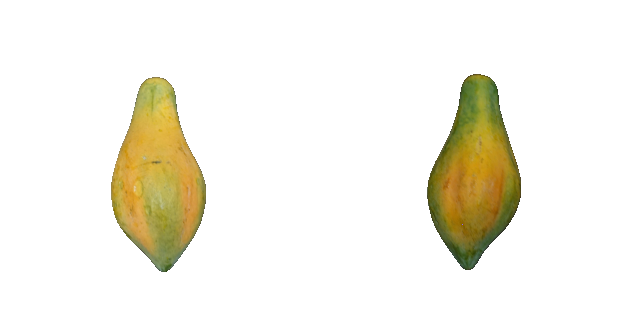

In [6]:
Image.fromarray(retult['remove_image'])

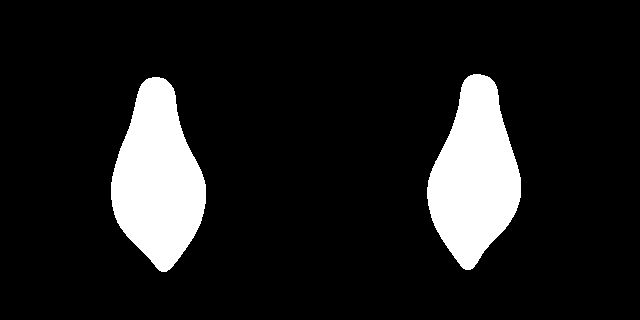

In [7]:
Image.fromarray(retult['mask_image'])

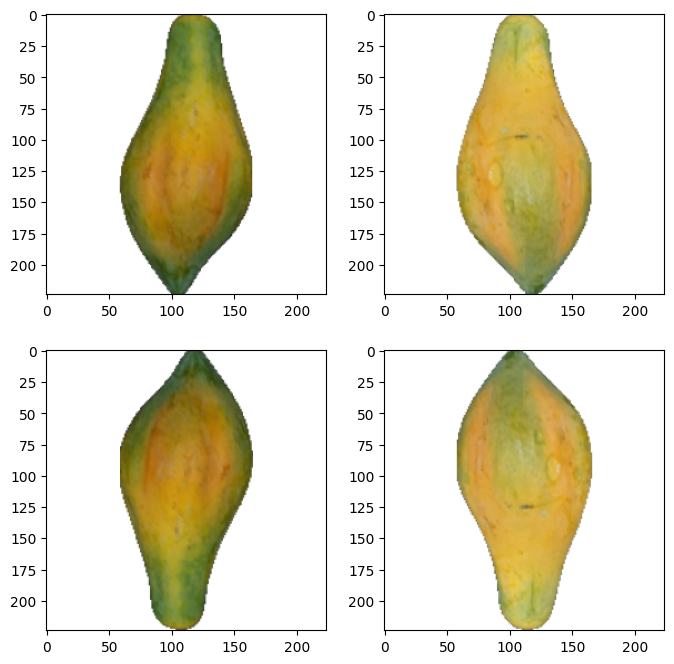

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(retult['rotate_img'][i-1])
plt.show()

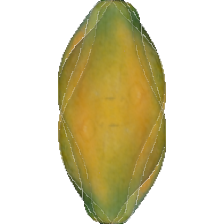

In [9]:
Image.fromarray(retult['merge_image'].astype('uint8'))